# Test for a simple regression problem

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

import sys
from twodlearn.feedforward import *
from twodlearn.datasets.Batch_generator import *

## 1. Create Dataset

In [2]:
train_X= np.expand_dims(np.linspace(0,10,100), -1)
train_y= np.sin(train_X)

test_X= np.expand_dims(np.linspace(0,10,1000), -1)
test_y= np.sin(test_X)

n_features= 1

print(train_X.shape)
print(train_y.shape)

(100, 1)
(100, 1)


#### normalization

In [3]:
std_data= np.std(train_X, 0)
mean_data= np.mean(train_X, 0)

for i in range(n_features):
    train_X[:,i]= (train_X[:,i]-mean_data[i])/std_data[i]
    test_X[:,i]= (test_X[:,i]-mean_data[i])/std_data[i]
print(np.std(train_X,0))
print(np.std(test_X,0))

[1.]
[0.99104005]


## 2. Batch Generators

In [4]:
batch_size = train_X.shape[0] #50
batch_size_test= test_X.shape[0]

## 2. Define the Model

In [5]:
sess = tf.InteractiveSession()

In [6]:
# Network parameters
n_inputs= n_features
n_outputs=  1
n_hidden = [30]

# for dropout
drop_prob = tf.placeholder(tf.float32)

# Define MLP Net
mlp_net= MlpNet( n_inputs, n_outputs, n_hidden, afunction= tf.sigmoid ,name='MlpNet')

# Define train setup
train= mlp_net.evaluate(keep_prob=drop_prob, name='train')
train.loss.init()
# Define test setup
test= mlp_net.evaluate(keep_prob=drop_prob, name='test')


# Optimizer.
optimizer = tf.train.AdamOptimizer(0.01).minimize(tf.convert_to_tensor(train.loss)) #0.001

## 3. Train the model

In [7]:
num_steps = 5000
n_logging = 100
n_test_logg = 10

tf.global_variables_initializer().run()
print('Initialized')

mean_loss= 0
train_accuracy= 0
for step in range(num_steps):
    batch_X= train_X
    batch_y= train_y
    
        
    feed_dict = {train.inputs : batch_X, train.loss.labels : batch_y, drop_prob:1.0}
    ops = [optimizer, tf.convert_to_tensor(train.loss), 
           tf.convert_to_tensor(train.output)]
    _, l, train_pred = sess.run(ops,feed_dict=feed_dict)
    mean_loss += l    
    
    if step%n_logging == 0:                
        # test
        pred = test.output.value.eval(feed_dict={test.inputs: test_X, drop_prob: 1.0})
            
        test_error = np.sum( np.power(pred-test_y, 2.0) )/2.0
        
        # print            
        print(step, ' | test:', test_error, ' | loss:', mean_loss/n_logging)
        mean_loss= 0
mean_loss = mean_loss/n_logging

Initialized
0  | test: 229.3272099595079  | loss: 0.004416625499725341
100  | test: 219.88009493613856  | loss: 0.4399086454510689
200  | test: 142.53608546423953  | loss: 0.391535239815712
300  | test: 60.09876310113784  | loss: 0.18796952173113823
400  | test: 17.423527418744612  | loss: 0.08554649874567985
500  | test: 4.343415745295052  | loss: 0.020359925637021662
600  | test: 1.2728101466855124  | loss: 0.00651620636228472
700  | test: 0.5214291248270915  | loss: 0.0029438985791057346
800  | test: 0.2619068959760906  | loss: 0.0019398235972039402
900  | test: 0.15916916041905516  | loss: 0.0015705199155490845
1000  | test: 0.1130193711430531  | loss: 0.0014110591157805174
1100  | test: 0.08859525159134234  | loss: 0.0013306317082606256
1200  | test: 0.07417282667878938  | loss: 0.0012862992996815592
1300  | test: 0.06430691871290749  | loss: 0.0012390475755091758
1400  | test: 0.057014889975343916  | loss: 0.0012253544584382326
1500  | test: 0.05613928717046677  | loss: 0.0012035

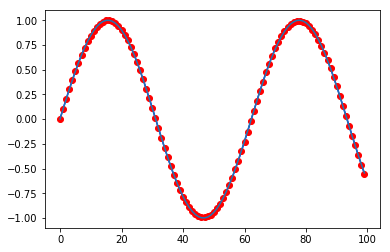

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

pred = train.output.value.eval(feed_dict={train.inputs: train_X, drop_prob: 1.0})

plt.plot(np.arange(pred.shape[0]), pred, 'b')
plt.plot(np.arange(pred.shape[0]), pred, 'ro')

plt.plot(np.arange(train_y.shape[0]), train_y)


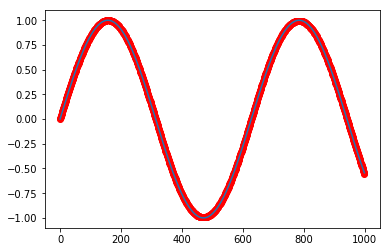

In [9]:
pred = test.output.value.eval(feed_dict={test.inputs: test_X, drop_prob: 1.0})

plt.plot(np.arange(pred.shape[0]), pred, 'b')
plt.plot(np.arange(pred.shape[0]), pred, 'ro')
plt.plot(np.arange(test_y.shape[0]), test_y)


In [10]:
assert (test_error<0.5) and ((mean_loss<0.001)), "Error of mlp higher than expected"
assert (sorted([w.name for w in tdl.get_trainable(mlp_net)]) ==
        sorted(['MlpNet/layers/DenseLayer/weights/W:0',
                'MlpNet/layers/AffineLayer/weights/W:0', 
                'MlpNet/layers/AffineLayer/bias/b:0',
                'MlpNet/layers/DenseLayer/bias/b:0'])), 'Naming convention incorrect'